In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-10-30 12:01:13.708567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 12:01:13.718291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 12:01:13.721273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 12:01:13.729378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
Z = np.array(data['R_max']).reshape(-1, 1)
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))
scaler_Z = MinMaxScaler(feature_range=(0, 1))

x = scaler_X.fit_transform(X)
z = scaler_Z.fit_transform(Z)

# Mask and scale only non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep the structure with zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten()

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

y_tr2, y_ts2, z_tr, z_ts = train_test_split(y, z, test_size=0.2, random_state=42)
y_ts2, y_vl, z_ts, z_vl = train_test_split(y_ts2, z_ts, test_size=0.01, random_state=42)

In [3]:
tuner_dir = 'trials'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# Define the DNN model with hyperparameter tuning
class DNNHyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=(x_ncols,)))
        model.add(layers.Dense(hp.Int('units_1', min_value=64, max_value=512, \
                                      step=64), activation='relu'))
        model.add(layers.Dense(hp.Int('units_2', min_value=64, max_value=512, \
                                      step=64), activation='relu'))
        model.add(layers.Dense(hp.Int('units_3', min_value=32, max_value=256, \
                                      step=64), activation='relu'))

        # Tunable depth (number of hidden layers)
        #for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 3 layers
        #    model.add(layers.Dense(hp.Int(f'units_{i}', min_value=32, \
        #                                  max_value=512, step=64), activation='relu'))

        model.add(layers.Dense(y_ncols, activation='relu'))
        
        model.compile(optimizer='adam', loss='mse')
        return model

tuner = kt.RandomSearch(
    DNNHyperModel(),
    objective='val_mae',
    max_trials=100,
    executions_per_trial=1,
    directory='trials'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', \
                                              min_delta=1.0e-6, patience=10)

# Print the summary of search space
tuner.search_space_summary()

I0000 00:00:1730232837.709090  409392 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730232837.765656  409392 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730232837.765962  409392 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730232837.768138  409392 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Search space summary
Default search space size: 3
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 64, 'sampling': 'linear'}


In [5]:
# Run search with variable batch sizes
tuner.search(
    x_tr, y_tr,
    epochs=200,
    validation_data=(x_ts, y_ts),
    batch_size=32,
    callbacks=[stop_early]
)

Trial 56 Complete [00h 00m 52s]
val_mae: 0.004793904721736908

Best val_mae So Far: 0.0028404411859810352
Total elapsed time: 00h 49m 27s

Search: Running Trial #57

Value             |Best Value So Far |Hyperparameter
64                |320               |units_1
448               |192               |units_2
96                |224               |units_3

Epoch 1/200
266/266 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0157 - mae: 0.0743 - val_loss: 0.0095 - val_mae: 0.0454
Epoch 2/200
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mae: 0.0438 - val_loss: 0.0087 - val_mae: 0.0409
Epoch 3/200
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086 - mae: 0.0402 - val_loss: 0.0085 - val_mae: 0.0389
Epoch 4/200
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085 - mae: 0.0387 - val_loss: 0.0085 - val_mae: 0.0382
Epoch 5/200
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - mae: 0.0377 - val_loss: 0.0079 - val_mae: 0.0355
Epoch 6/200
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2

KeyboardInterrupt: 

In [6]:
tuner.results_summary(num_trials=1)

Results summary
Results in trials/untitled_project
Showing 1 best trials
Objective(name="val_mae", direction="min")

Trial 009 summary
Hyperparameters:
units_1: 320
units_2: 192
units_3: 224
Score: 0.0028404411859810352


In [7]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 320)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        61,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 224)            │        43,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        22,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,564 (510.02 KB)

 Trainable params: 130,564 (510.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', \
                                              min_delta=1.0e-6, patience=5)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=8, callbacks=[stop_early])

Epoch 1/1000


2024-10-29 17:05:16.224175: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 4 bytes spill stores, 4 bytes spill loads



1060/1063 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102 - mae: 0.0448

2024-10-29 17:05:21.098318: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 4 bytes spill stores, 4 bytes spill loads



1063/1063 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0102 - mae: 0.0448 - val_loss: 0.0038 - val_mae: 0.0207
Epoch 2/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0038 - mae: 0.0207 - val_loss: 0.0038 - val_mae: 0.0207
Epoch 3/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - mae: 0.0195 - val_loss: 0.0037 - val_mae: 0.0188
Epoch 4/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - mae: 0.0192 - val_loss: 0.0037 - val_mae: 0.0190
Epoch 5/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0034 - mae: 0.0177 - val_loss: 0.0033 - val_mae: 0.0167
Epoch 6/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0032 - mae: 0.0166 - val_loss: 0.0028 - val_mae: 0.0160
Epoch 7/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0027 - mae: 0.0142 - val_loss: 0.0027 - val_mae: 0.0135
Epoch 8/1000
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0027 - mae: 0.0140 - val_loss: 0.0027 - val_mae: 0.0139
Epoch 9/1000
1063/1063 ━━━━━━━━━━━━━

In [9]:
loss = best_model.predict(x_vl)
print("Loss MSE= ", loss[0])

# Save the best model
best_model.save("best_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Loss MSE=  [0.84126854 0.6732047  0.5660343  0.4907403  0.43516135 0.39357135
 0.36076862 0.33513767 0.31374377 0.29551512 0.28023797 0.26782414
 0.25644946 0.24699837 0.23940787 0.23360762 0.22864133 0.22501312
 0.22270161 0.2201741  0.21902195 0.21818723 0.2175902  0.21780664
 0.21773317 0.21838741 0.21885371 0.21996558 0.22099921 0.22221774
 0.22300074 0.22471689 0.22592951 0.2277072  0.22914484 0.23068054
 0.23217478 0.23365211 0.23519069 0.23672366 0.23808739 0.23977557
 0.24091816 0.242222   0.24381511 0.2448359  0.24592908 0.24689385
 0.24786167 0.24869536 0.24934402 0.24981041 0.2501401  0.25023514
 0.25003523 0.24944891 0.24867293 0.24785525 0.24686837 0.245865
 0.24405564 0.24184549 0.23999009 0.23798457 0.23557521 0.22647896
 0.22404927 0.21943146 0.2054628  0.16810293 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

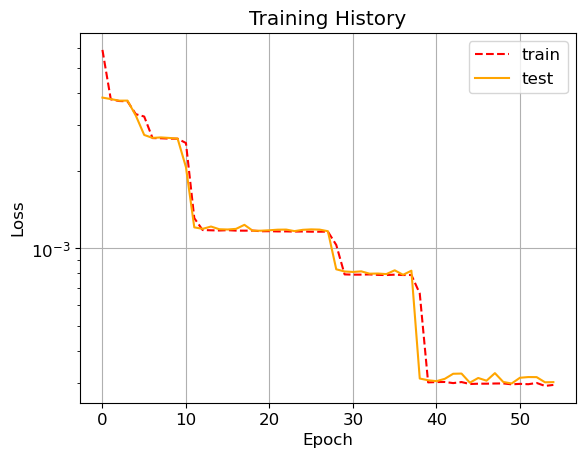

In [10]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

In [ ]:
# Assume y_pr contains the normalized predictions and y_vl is the validation data
y_pr = best_model.predict(x_vl)

# Initialize arrays to store denormalized values
Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

# Process each row individually
for i in range(y_pr.shape[0]):
    # Step 1: Identify the index of the first negative value in the row
    if np.any(y_pr[i] < 0):  # Check if there is any negative value
        i_nz = np.where(y_pr[i] < 0)[0][0]
        
        # Step 2: Set all values after the first negative value to zero
        y_pr[i, i_nz:] = 0

    # Step 3: Create a mask to identify non-zero values for denormalization
    nz_pr = y_pr[i] != 0
    nz_dt = y_vl[i] != 0

    # Step 4: Apply inverse_transform only on non-zero values
    if np.any(nz_pr):  # Check if there are any non-zero values
        Y_pr[i, nz_pr] = scaler_Y.inverse_transform(y_pr[i, nz_pr].reshape(-1, 1)).flatten()
    if np.any(nz_dt):  # Check if there are any non-zero values in the original validation data
        Y_vl[i, nz_dt] = scaler_Y.inverse_transform(y_vl[i, nz_dt].reshape(-1, 1)).flatten()

# Plot the results
m = np.linspace(0.2, 3.0, 100)
for i in range(22):
    plt.plot(Y_vl[i], m, label='Data', color='green', linestyle='--')
    plt.plot(Y_pr[i], m, label='Predicted', color='red')
    plt.xlabel("Radius")
    plt.ylabel("Mass")
    plt.legend()
    plt.show()


In [ ]:
def post_process_radius(y_pr):
    for i in range(len(y_pr)):
        # Get the current predicted radius vector for the i-th sample
        radii = y_pr[i]

        # Find the last non-zero radius index
        i_max = np.min(np.nonzero(radii))

        # Step 1: Set all values after the last non-zero value to zero
        radii[i_max + 1:] = 0

        # Step 2: Linearly interpolate oscillating values between zero and last non-zero
        for j in range(i_max - 1, 0, -1):
            if radii[j] < 0 or radii[j] > radii[j + 1]:
                # Linearly interpolate between j-1 and the last valid non-zero value
                radii[j] = (radii[j-1] + radii[j+1]) / 2

        # Update the radius vector in the prediction array
        y_pr[i] = radii

    return y_pr

# Assuming y_pr is the predicted radius output from your model
y_pr = model.predict(x_vl)
print(y_pr[3])
y_pr2 = post_process_radius(y_pr)
print(y_pr2[3])
